# AIhub data annotation 변경

In [94]:
import glob
import xml.etree.ElementTree as ET
import re
import shutil
import tqdm
import pandas as pd
from PIL import Image
import cv2

def convert_yolo_coord(object_name, img_width, img_height, x1, y1, x2, y2):
  # class_id는 CLASS_NAMES 리스트에서 index 번호로 추출. 
    class_id = CLASS_NAMES.index(object_name)
    # 중심 좌표와 너비, 높이 계산. 
    center_x = (x1 + x2)/2
    center_y = (y1 + y2)/2
    width = x2 - x1
    height = y2 - y1
    # 원본 이미지 기준으로 중심 좌표와 너비 높이를 0-1 사이 값으로 scaling
    center_x_norm = center_x / img_width
    center_y_norm = center_y / img_height
    width_norm = width / img_width
    height_norm = height / img_height

    return class_id, round(center_x_norm, 7), round(center_y_norm, 7), round(width_norm, 7), round(height_norm, 7)

In [142]:
def convert_aihub_yolo(flag = 'train', CLASS_NAMES = [])
    if flag == 'val':
        CLASS_DATA = [{'code':i,'name':v,'volume':None,'width':None,'length':None,'height':None} for i,v in enumerate(CLASS_NAMES)]
    
    label_list = glob.glob('./dataset/'+flag+'/label/*')

    data = ['volume','width','length','height']
    for a, class_ in tqdm.tqdm(enumerate(label_list)):
        try:
            class_num = a
            class_name = class_[class_.find('_')+1:]
            if class_name not in CLASS_NAMES: CLASS_NAMES.append(class_name)
            label_data = glob.glob(class_+'/*')

            for b, v in enumerate(label_data):
                if  flag == 'val' and 'meta' in v:
                    input_xml_file = v
                    class_id = CLASS_NAMES.index(class_name)
                    tree = ET.parse(input_xml_file)
                    img_node = tree.find('div_cd')
                    for c in data:
                        if CLASS_DATA[class_id][c] == None:
                            d = img_node.find(c).text
                            if d != None:
                                CLASS_DATA[class_id][c] = re.sub(r'[^0-9]', '', d)
                else:
                    input_xml_file = v
                    tree = ET.parse(input_xml_file)
                    img_width = int(tree.find('size').find('width').text)
                    img_height = int(tree.find('size').find('height').text)
                    img_path = re.sub('xml','jpg',re.sub('label','raw_images',v))

                    output_txt_file = './dataset/labels/'+flag+ '/'+ str(a) + '_' + str(b) + '.txt'
                    output_img_file = './dataset/images/'+flag+'/' + str(a) + '_' + str(b) + '.jpg'
                    shutil.copy(img_path, output_img_file)

                    with open(output_txt_file, 'w') as output_fpointer:
                        for obj in tree.findall('object'):
                            xmlbox = obj.find('bndbox')
                            x1 = int(xmlbox.find('xmin').text)
                            y1 = int(xmlbox.find('ymin').text)
                            x2 = int(xmlbox.find('xmax').text)
                            y2 = int(xmlbox.find('ymax').text)
                            if (x1 < 0) or (x2 < 0) or (y1 < 0) or (y2 < 0):
                                break
                            class_id, cx_norm, cy_norm, w_norm, h_norm = convert_yolo_coord(class_name, img_width, img_height, x1, y1, x2, y2)
                            value_str = ('{0} {1} {2} {3} {4}').format(class_id, cx_norm, cy_norm, w_norm, h_norm)
                            output_fpointer.write(value_str+'\n')
        except Exception as e:
            print('에러발생',v, e)
            
    if flag == 'train':
        return CLASS_NAMES
    elif flag == 'val':
        return CLASS_DATA
        
        

76it [00:01, 42.98it/s]


In [145]:
class_names = convert_aihub_yolo(flag = 'train')
CLASS_DATA = convert_aihub_yolo(flag = 'val', CLASS_NAMES = class_names)

pd.DataFrame(CLASS_DATA).to_csv('product_meta.csv',index=False,encoding = 'CP949')

# AIhub Data Bbox 확인

In [75]:
def convert_(img,bbox):
    img_width, img_height = img.shape[:2]
    
    center_x_norm, center_y_norm, width_norm, height_norm = bbox
    
    center_x = center_x_norm * img_width
    center_y = center_y_norm * img_height
    width = width_norm * img_width
    height = height_norm * img_height
    
    x1 = int(center_x - (width / 2))
    x2 = int(center_x + (width / 2))
    y1 = int(center_y - (height / 2))
    y2 = int(center_y + (height / 2))
    
    return (x1,y1),(x2,y2)

In [83]:
def bbox_check(file_name):
    img = './dataset/images/val/'+file_name+'.jpg'
    ann = './dataset/labels/val/'+file_name+'.txt'
    
    img = cv2.imread(img)
    file = open(ann, "r")
    bbox = []
    
    while True:
        line = file.readline()
        if not line:
            break
        bbox.append([float(re.sub('\n','',i)) for i in line.split(' ')[1:]])
    file.close()
    
    for i in bbox:
        st, en = convert_(img,i)
        img = cv2.rectangle(img, st,en,(0,0,0),2)
        
    return Image.fromarray(img)

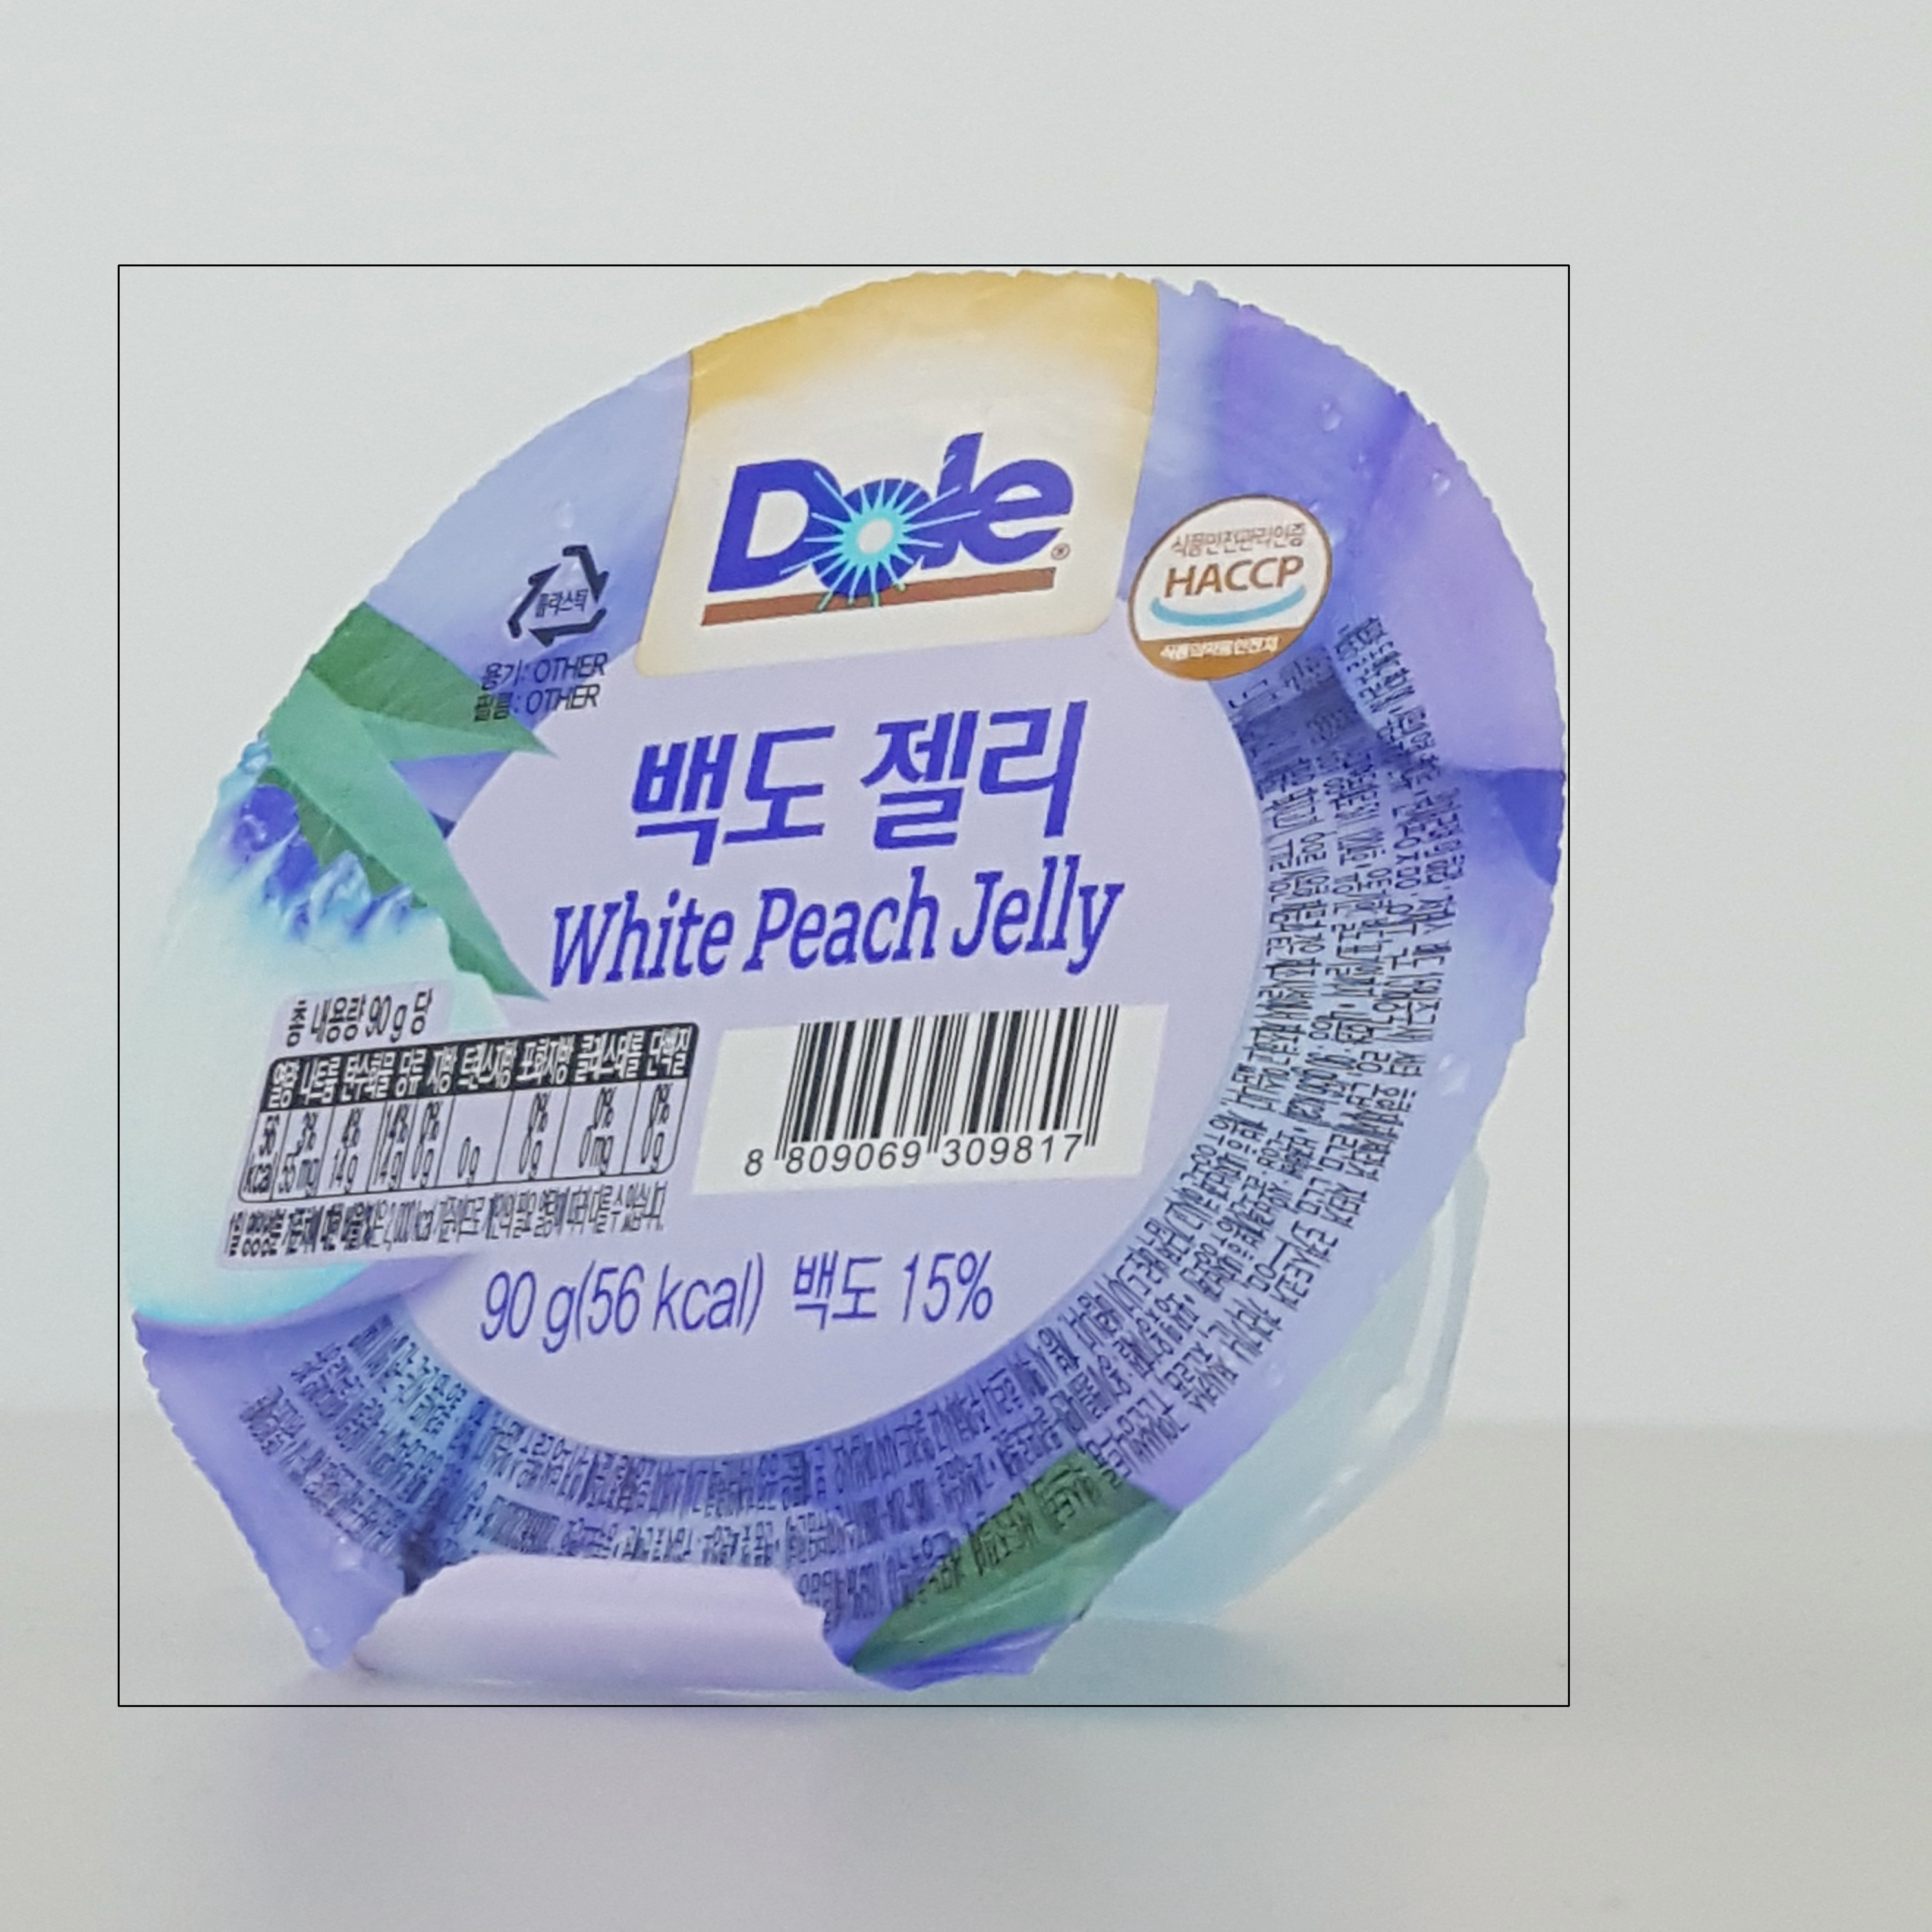

In [98]:
file_name = '10_0'

bbox_check(file_name)

# 학습용 Yaml 다운

In [100]:
!wget -O ./ox_pet.yaml https://raw.githubusercontent.com/chulminkw/DLCV/master/data/util/ox_pet.yaml

--2022-08-16 11:21:37--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/util/ox_pet.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
접속 raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 754 [text/plain]
Saving to: ‘./ox_pet.yaml’

./ox_pet.yaml       100%[===================>]     754  --.-KB/s    in 0s      

2022-08-16 11:21:37 (29.5 MB/s) - ‘./ox_pet.yaml’ saved [754/754]



In [2]:
import torch

# GPU 사용 가능 -> True, GPU 사용 불가 -> False
print(torch.cuda.is_available())
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

True


In [6]:
# train - 콘솔에서 실행
# !python3 train.py --img 640 --batch 16 --epochs 20 --data ./ox_pet.yaml --weights yolov5m.pt --device 0 --name pet --exist-ok  

Traceback (most recent call last):
  File "train.py", line 27, in <module>
    import torch.distributed as dist
ModuleNotFoundError: No module named 'torch.distributed'


In [10]:
# test - console 실행
# python3 detect.py --source ./dataset/images/val/1_1.jpg --weights ./runs/train/food2/weights/best.pt --conf 0.2 --name=run_image --exist-ok --line-thickness 2